In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

## Focusing

In [3]:
focusing_result_files = {
    "r5": "/home/hieule/research/saris_revised/local_assets/hallway_focus_3_agents_r5_eval/env_rollout_images.pt",
    "r7": "/home/hieule/research/saris_revised/local_assets/hallway_focus_3_agents_r7_eval/env_rollout_images.pt",
    "r9": "/home/hieule/research/saris_revised/local_assets/hallway_focus_3_agents_r9_eval/env_rollout_images.pt",
    "r11": "/home/hieule/research/saris_revised/local_assets/hallway_focus_3_agents_r11_eval/env_rollout_images.pt",
}

focusing_all_results = {
    "r5": torch.load(focusing_result_files["r5"], weights_only=False),
    "r7": torch.load(focusing_result_files["r7"], weights_only=False),
    "r9": torch.load(focusing_result_files["r9"], weights_only=False),
    "r11": torch.load(focusing_result_files["r11"], weights_only=False),
}

In [4]:
focusing_cur_rssis = {}

for key, result in focusing_all_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    focusing_cur_rssis[key] = rss

rss shape for r5: torch.Size([4, 1, 400, 3])
rss shape for r7: torch.Size([4, 1, 400, 3])
rss shape for r9: torch.Size([4, 1, 400, 3])
rss shape for r11: torch.Size([4, 1, 400, 3])


In [5]:
def smooth(data, window_size=5):
    """Smooth the data using a Gaussian moving average filter."""
    # first, pad the data with zeros
    pad_size = window_size + 3
    data = np.pad(data, (pad_size, pad_size), mode="edge")
    # then, apply the Gaussian moving average filter
    kernel = np.exp(-0.5 * (np.arange(-pad_size, pad_size + 1) / 1) ** 2)
    kernel /= np.sum(kernel)
    smoothed_data = np.convolve(data, kernel, mode="same")
    # remove the padding
    smoothed_data = smoothed_data[pad_size:-pad_size]
    return smoothed_data

def plot_rssi(rssis, title, ymin=-100, ymax=-55, is_smooth=True, colors=None):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    for key, rssi in rssis.items():
        rssi_mean = rssi.mean(dim=0)[0].cpu().numpy()
        
        # smooth data for every 20 steps only
        rfsss = []
        last_10_each = []
        for i in range(0, len(rssi_mean), 20):
            tmp_rfs = rssi_mean[i:i+20]
            last_10_each.append(tmp_rfs[-10:])
            tmp_rfs = smooth(tmp_rfs, window_size=3)
            rfsss.append(tmp_rfs)
        if is_smooth:
            rssi_mean = np.concatenate(rfsss).reshape(-1)
        last_10_each = np.concatenate(last_10_each).reshape(-1)
        last_10_each_avg = last_10_each.mean()
        # plot the single value as a horizonaltal line of (last_10_each_avg)
        ax.axhline(y=last_10_each_avg, color=colors[key], linestyle='--', label=f'{key} avg: {last_10_each_avg:.2f} dBm')
        
        rssi_std = rssi.std(dim=0)[0].cpu().numpy()
        ax.plot(rssi_mean, label=f'{key}', alpha=0.7, color=colors[key])
        ax.fill_between(range(len(rssi_mean)), 
                        rssi_mean - rssi_std, 
                        rssi_mean + rssi_std, 
                        alpha=0.1, color=colors[key])
    if title != "":
        ax.set_title(title, fontsize=16)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('RSSI (dBm)', fontsize=14)
    ax.legend(loc='lower right')
    plt.tight_layout()
    ax.grid(True)
    ax.xaxis.set_major_locator(plt.MultipleLocator(20))
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

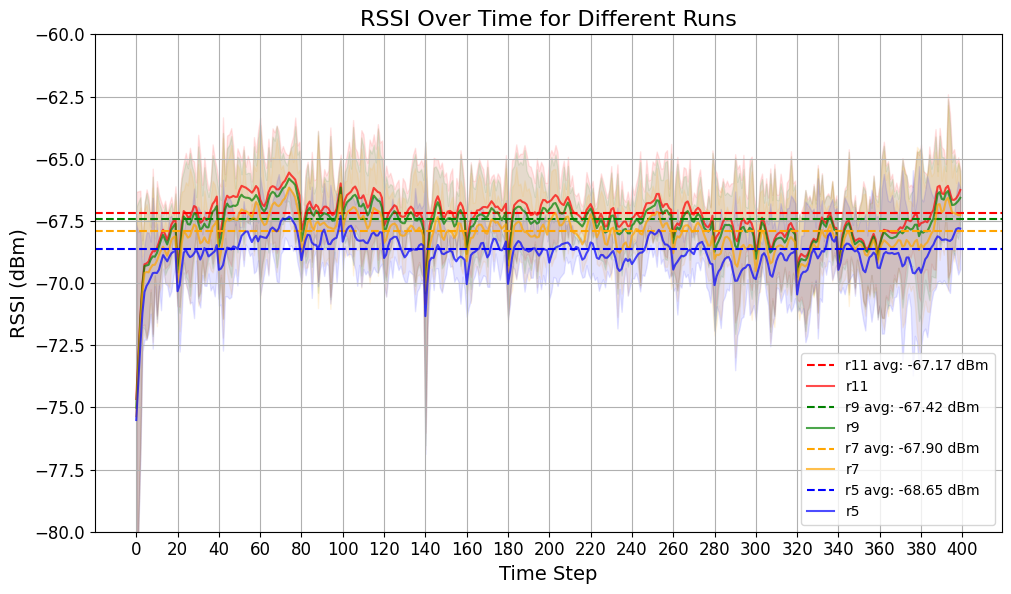

In [6]:
focusing_rssis = {}
for key, rssi in reversed(focusing_cur_rssis.items()):
    tmp = rssi.mean(dim=-1)
    focusing_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
focusing_colors = {
        "r5": "blue",
        "r7": "orange",
        "r9": "green",
        "r11": "red",}
plot_rssi(focusing_rssis, "RSSI Over Time for Different Runs", ymin=-80, ymax=-60, colors=focusing_colors)

### Zoomed-in View

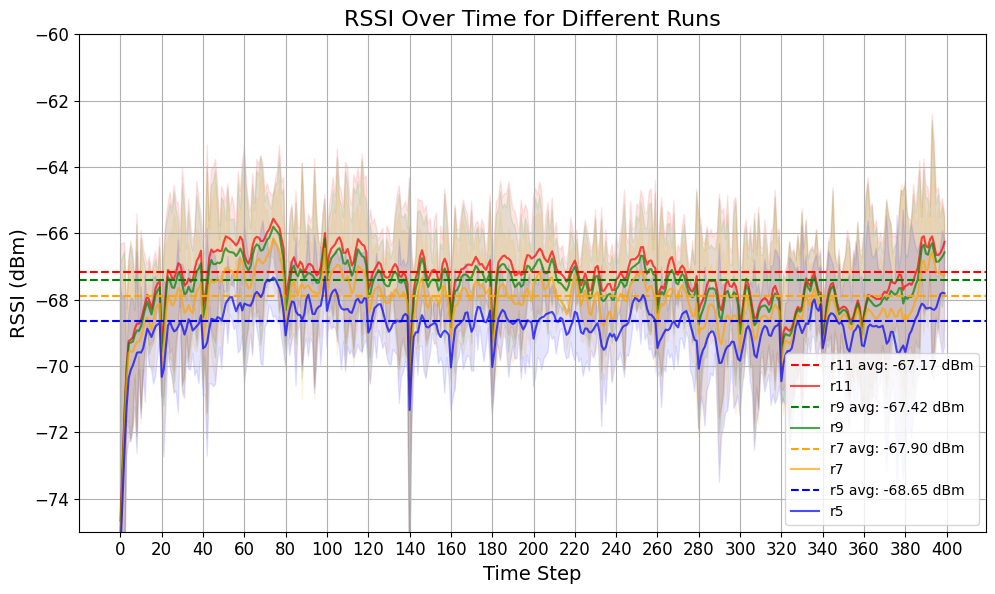

In [8]:
plot_rssi(focusing_rssis, "RSSI Over Time for Different Runs", ymin=-75, ymax=-60, colors=focusing_colors)

### No Smooth

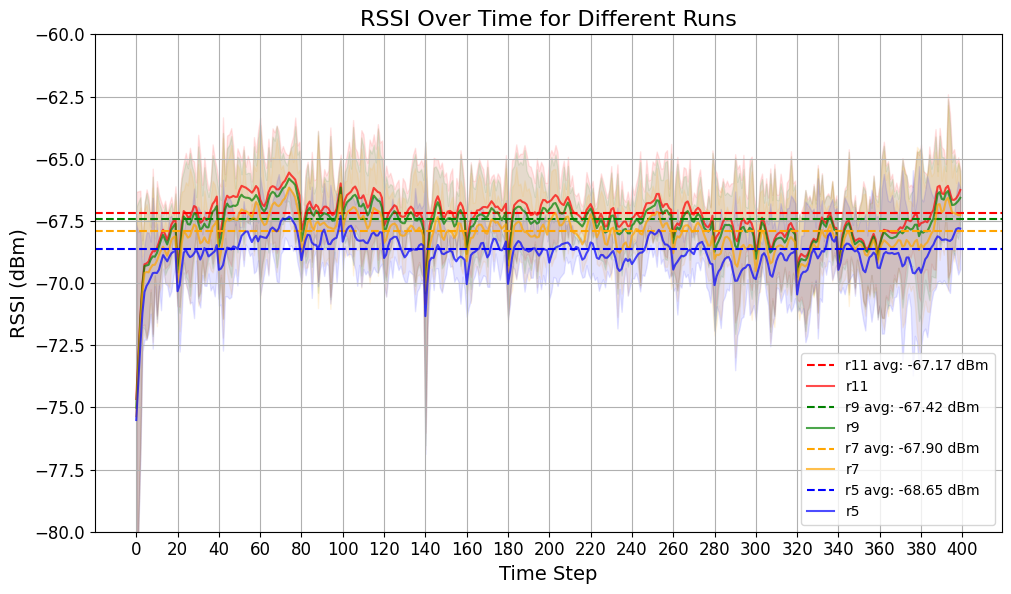

In [9]:
plot_rssi(focusing_rssis, "RSSI Over Time for Different Runs", ymin=-80, ymax=-60, is_smooth=True, colors=focusing_colors)

## Column-based control

In [10]:
col_result_files = {
    # "r5c9": "/home/hieule/research/saris_revised/local_assets/hallway_ma_tracking_eval_small/env_rollout_images.pt",
    "r7": "/home/hieule/research/saris_revised/local_assets/hallway_1ue_ma_c80_noshared_params_tracking_eval-20250722T045133Z-1-001/hallway_1ue_ma_c80_noshared_params_tracking_eval/env_rollout_images.pt",
    # "r9c9": "/home/hieule/research/saris_revised/local_assets/hallway_ma_tracking_eval_mid/env_rollout_images.pt",
    # "r11c9": "/home/hieule/research/saris_revised/local_assets/hallway_ma_tracking_eval_big/env_rollout_images.pt",
}

col_all_results = {
    # "r5c9": torch.load(col_result_files["r5c9"], weights_only=False),
    "r7": torch.load(col_result_files["r7"], weights_only=False),
    # "r9c9": torch.load(col_result_files["r9c9"], weights_only=False),
    # "r11c9": torch.load(col_result_files["r11c9"], weights_only=False),
}

rss shape for r7: torch.Size([4, 1, 400, 3])


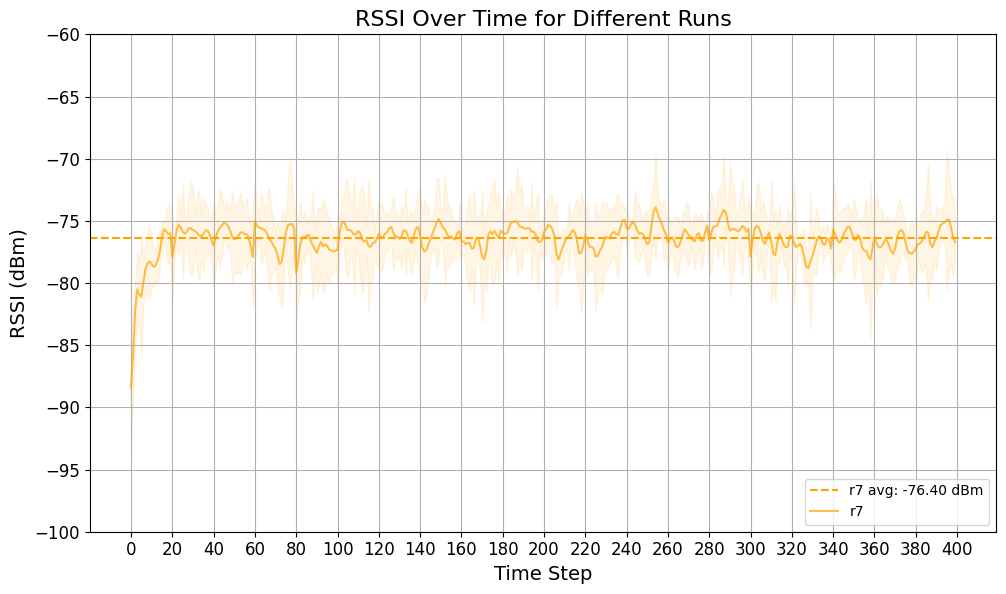

In [11]:
col_cur_rssis = {}
for key, result in col_all_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    col_cur_rssis[key] = rss

col_rssis = {}
for key, rssi in reversed(col_cur_rssis.items()):
    tmp = rssi.mean(dim=-1)
    col_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
col_colors = {
        "r5": "blue",
        "r7": "orange",
        "r9": "green",
        "r11": "red",}
plot_rssi(col_rssis, "RSSI Over Time for Different Runs", ymin=-100, ymax=-60, colors=col_colors)

## Plot RSSI between beam-focusing and column-based control

In [12]:
hex_result_files = {
    # "hex_2ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_2_agents_hex_eval/env_rollout_images.pt",
    "hex_3ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_3_agents_hex_eval/env_rollout_images.pt",
    # "hex_4ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_4_agents_hex_eval/env_rollout_images.pt",
}

hex_all_results = {
    # "hex_2ue": torch.load(hex_result_files["hex_2ue"], weights_only=False),
    "hex_3ue": torch.load(hex_result_files["hex_3ue"], weights_only=False),
    # "hex_4ue": torch.load(hex_result_files["hex_4ue"], weights_only=False),
}

rss shape for column-based: torch.Size([4, 1, 400, 3])
rss shape for beamfocusing: torch.Size([4, 1, 400, 3])
rss shape for hexagonal: torch.Size([4, 1, 400, 3])


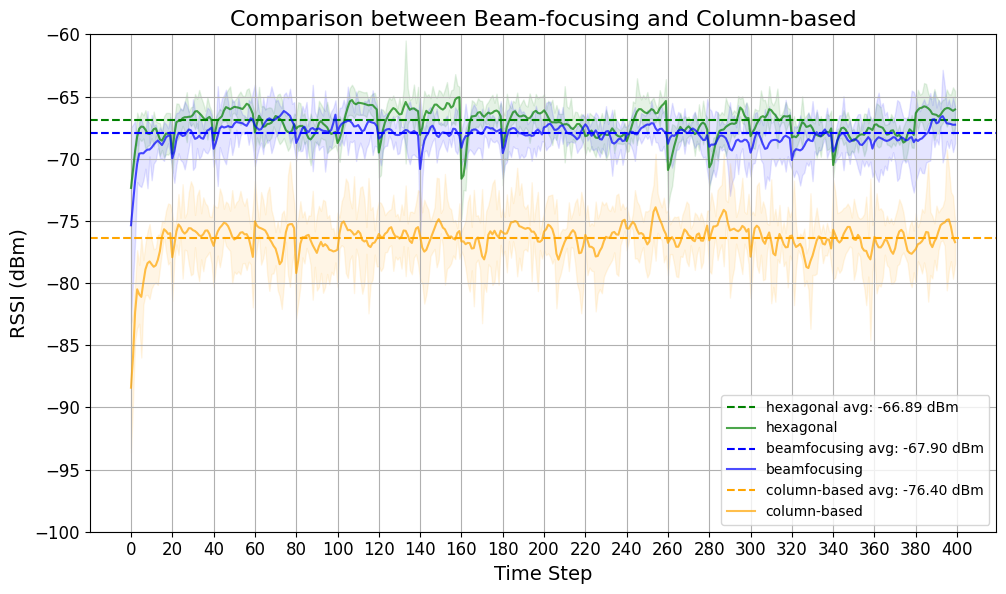

In [13]:
comparing_results = {
    "column-based": col_all_results["r7"],
    "beamfocusing": focusing_all_results["r7"],
    "hexagonal": hex_all_results["hex_3ue"],
}
comparing_cur_rssis = {}
for key, result in comparing_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    comparing_cur_rssis[key] = rss
    
comparing_rssis = {}
for key, rssi in reversed(comparing_cur_rssis.items()):
    tmp = rssi.mean(dim=-1)
    comparing_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
comparing_colors = {
        "column-based": "orange",
        "beamfocusing": "blue",
        "hexagonal": "green",
        # "r11": "red",
        }
plot_rssi(comparing_rssis, "Comparison between Beam-focusing and Column-based", ymin=-100, ymax=-60, colors=comparing_colors)

## Plot RSSI with different numbers of users

In [14]:
multiuser_files = {
    "focus_2ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_2_agents_eval/env_rollout_images.pt",
    # "hex_2ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_2_agents_hex_eval/env_rollout_images.pt",
    "focus_3ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_3_agents_r7_eval/env_rollout_images.pt",
    "hex_3ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_3_agents_hex_eval/env_rollout_images.pt",
    "focus_4ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_4_agents_eval/env_rollout_images.pt",
    # "hex_4ue": "/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_4_agents_hex_eval/env_rollout_images.pt",
}

multiuser_results = {
    "focus_4ue": torch.load(multiuser_files["focus_4ue"], weights_only=False),
    "focus_3ue": torch.load(multiuser_files["focus_3ue"], weights_only=False),
    "focus_2ue": torch.load(multiuser_files["focus_2ue"], weights_only=False),
    # "hex_4ue": torch.load(multiuser_files["hex_4ue"], weights_only=False),
    "hex_3ue": torch.load(multiuser_files["hex_3ue"], weights_only=False),
    # "hex_2ue": torch.load(multiuser_files["hex_2ue"], weights_only=False),
}

rss shape for focus_4ue: torch.Size([4, 1, 400, 4])
rss shape for focus_3ue: torch.Size([4, 1, 400, 3])
rss shape for focus_2ue: torch.Size([4, 1, 400, 2])
rss shape for hex_3ue: torch.Size([4, 1, 400, 3])


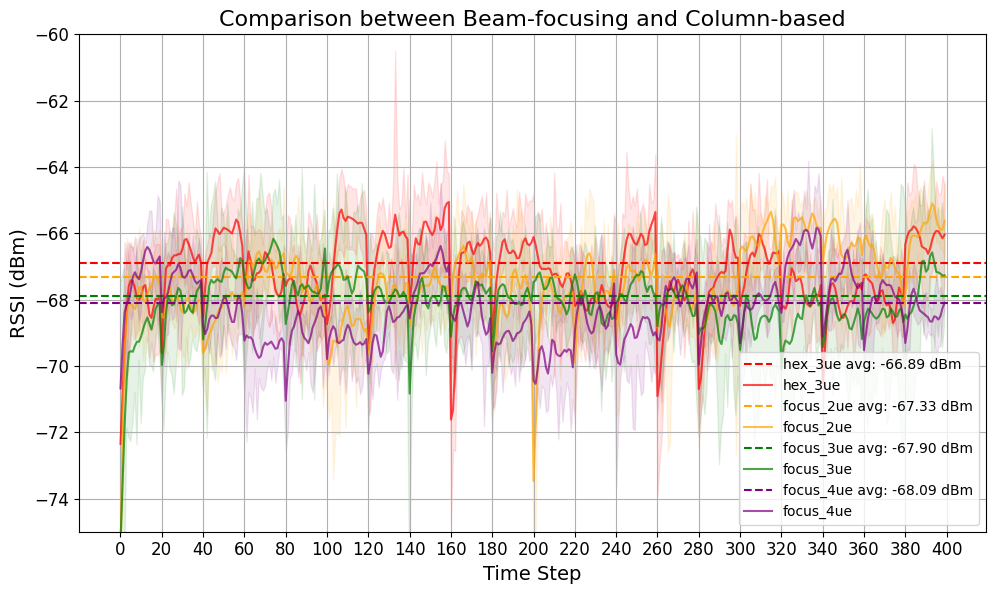

In [15]:
multiuser_cur_rssis = {}
for key, result in multiuser_results.items():
    rss = result["agents", "cur_rss"].cpu()
    rss = [rss[..., 0, i:i+1] for i in range(rss.shape[-1])]
    rss = torch.cat(rss, dim=-1)
    print(f"rss shape for {key}: {rss.shape}")
    multiuser_cur_rssis[key] = rss
    
multiuser_rssis = {}
for key, rssi in reversed(multiuser_cur_rssis.items()):
    tmp = rssi.mean(dim=-1)
    multiuser_rssis[key] = 10 * torch.log10(tmp) + 30  # Convert to dBm
multiuser_colors = {
        "focus_2ue": "orange",
        # "hex_2ue": "blue",
        "focus_3ue": "green",
        "hex_3ue": "red",
        "focus_4ue": "purple",
        # "hex_4ue": "brown",
        }
plot_rssi(multiuser_rssis, "Comparison between Beam-focusing and Column-based", ymin=-75, ymax=-60, colors=multiuser_colors)

In [19]:
ga_results = torch.load('/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r7/best_focal_point_0.pt', weights_only=False)
ga_results.keys()

dict_keys(['best_focal_point', 'td', 'history'])

In [16]:
ga_files = []

for file in glob.glob('/home/hieule/research/saris_revised/local_assets/Hallway_L/hallway_focus_ga_r7/*.pt'):
    if 'best_focal_point' in file:
        ga_files.append(file)
ga_files.sort(key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))

bests = []
for file in ga_files:
    ga_results = torch.load(file, weights_only=False)
    bests.append(np.mean(ga_results['best_rssi']))
    
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(bests)*20)[::20], bests, marker='o', label='Best RSSI', color='orange')
ax.set_title('Best RSSI Over Generations', fontsize=16)
ax.set_xlabel('Generation', fontsize=14)
ax.set_ylabel('RSSI (dBm)', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

KeyError: 'best_rssi'

## Plot for first seed

In [17]:
rssis_0 = {}
for key, rssi in cur_rssis.items():
    tmp = rssi[0].mean(dim=-1)
    rssis_0[key] = 10 * torch.log10(tmp.unsqueeze(0)) + 30  # Convert to dBm
    print(f"rssis_0[{key}]: {rssis_0[key].shape}")
    print(f"{rssis_0[key][0, 0, 50]} dBm")

rssis_0[r5c9]: torch.Size([1, 1, 400])
-73.92749786376953 dBm
rssis_0[r7c9]: torch.Size([1, 1, 400])
-80.33326721191406 dBm
rssis_0[r9c9]: torch.Size([1, 1, 400])
-73.91043090820312 dBm
rssis_0[r11c9]: torch.Size([1, 1, 400])
-73.89984130859375 dBm


key: r5c9, rssi shape: torch.Size([1, 1, 400])
key: r7c9, rssi shape: torch.Size([1, 1, 400])
key: r9c9, rssi shape: torch.Size([1, 1, 400])
key: r11c9, rssi shape: torch.Size([1, 1, 400])


/tmp/ipykernel_13130/2733483176.py:6: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  rssi_std = rssi.std(dim=0)[0]


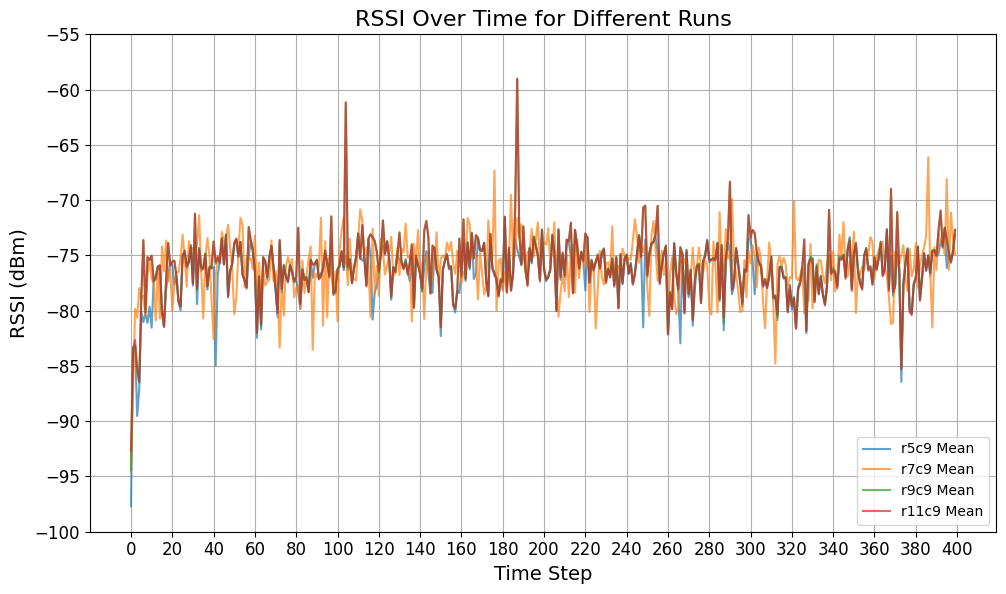

In [6]:
rssis_0 = {}
for key, rssi in cur_rssis.items():
    tmp = rssi[0].mean(dim=-1)
    rssis_0[key] = 10 * torch.log10(tmp.unsqueeze(0)) + 30  # Convert to dBm
plot_rssi(rssis_0, "RSSI Over Time for Different Runs")

## Sum RSSI of all users with different seeds

key: r5c9, rssi shape: torch.Size([3, 1, 400])
key: r7c9, rssi shape: torch.Size([4, 1, 400])
key: r11c9, rssi shape: torch.Size([3, 1, 400])


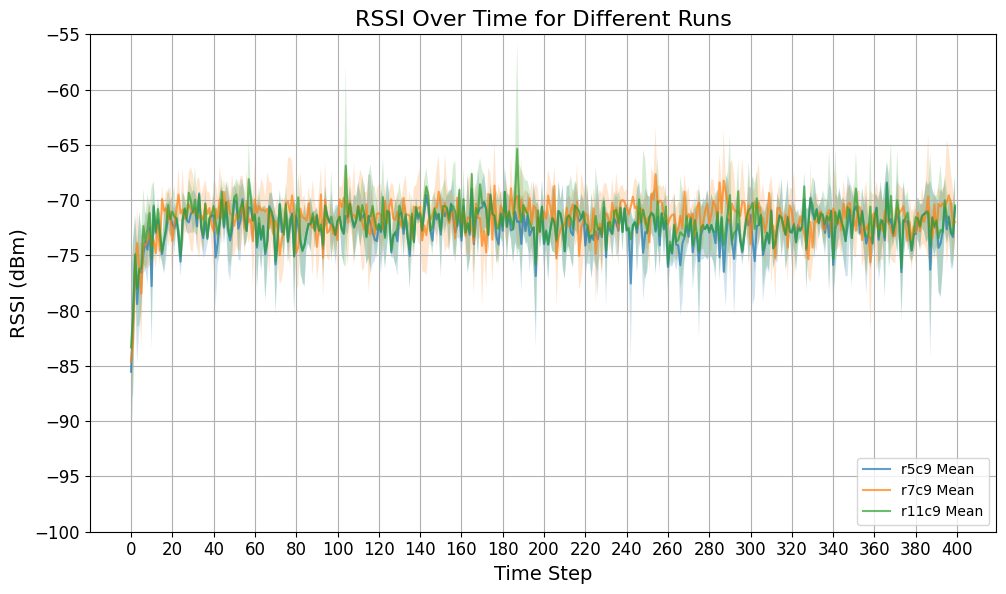

In [4]:
def plot_rssi(rssis, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    for key, rssi in rssis.items():
        print(f"key: {key}, rssi shape: {rssi.shape}")
        rssi_mean = rssi.mean(dim=0)[0]
        rssi_std = rssi.std(dim=0)[0]
        ax.plot(rssi_mean, label=f'{key} Mean', alpha=0.7)
        ax.fill_between(range(len(rssi_mean)), 
                        rssi_mean - rssi_std, 
                        rssi_mean + rssi_std, 
                        alpha=0.2)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Time Step', fontsize=14)
    ax.set_ylabel('RSSI (dBm)', fontsize=14)
    ax.legend(loc='lower right')
    plt.tight_layout()
    ax.grid(True)
    ax.xaxis.set_major_locator(plt.MultipleLocator(20))
    ax.set_ylim(-100, -55)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

sum_rssis = {}
for key, rssi in cur_rssis.items():
    sum_rssis[key] = rssi.sum(dim=-1)
    sum_rssis[key] = 10 * torch.log10(sum_rssis[key]) + 30  # Convert to dBm
plot_rssi(sum_rssis, "RSSI Over Time for Different Runs")

## Mean RSSI of all users with different seeds

key: r5c9, rssi shape: torch.Size([3, 1, 400])
key: r7c9, rssi shape: torch.Size([4, 1, 400])
key: r11c9, rssi shape: torch.Size([3, 1, 400])


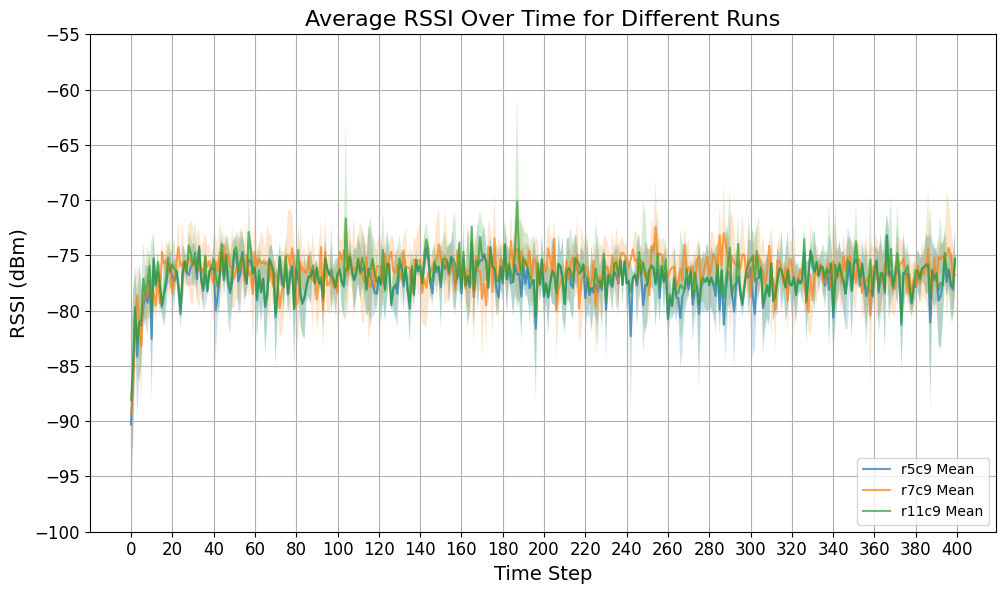

In [5]:
avg_rssis = {}
for key, rssi in cur_rssis.items():
    avg_rssi = rssi.mean(dim=-1)
    avg_rssis[key] = 10 * torch.log10(avg_rssi) + 30  # Convert to dBm
plot_rssi(avg_rssis, "Average RSSI Over Time for Different Runs")

In [ ]:
    
# rfs_sum = 10 ** (rfs / 10)  # Convert dBm to linear scale
rfs_sum = rfs.sum(dim=-1)
rfs_sum = 10 * torch.log10(rfs_sum) + 30  # Convert dBm
all_rfs_sum = rfs_sum.mean(dim=0)[0]
all_rfs_std = rfs_sum.std(dim=0)[0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(all_rfs_sum, label='Mean of total RSSI of all users', color='blue')
ax.fill_between(range(len(all_rfs_sum)), 
                all_rfs_sum - all_rfs_std, 
                all_rfs_sum + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ax.set_title('Total RSSI of All Users', fontsize=16)
ax.set_xlabel('Time Step',  fontsize=14)
ax.set_ylabel('RSSI (dBm)',  fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

In [6]:
target_pos = all_results["r5c9"]["agents", "target_pos"]
target_pos[0,0,0]

tensor([[-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000],
        [-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000],
        [-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000]], device='cuda:0')

In [8]:
target_pos = all_results["r11c9"]["agents", "target_pos"]
target_pos[0,0,0]

tensor([[-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000],
        [-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000],
        [-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000]], device='cuda:0')

In [ ]:

results = torch.load('/home/hieule/research/saris_revised/local_assets/hallway_1ue_ma_c80_noshared_params_tracking_eval-20250722T045133Z-1-001/hallway_1ue_ma_c80_noshared_params_tracking_eval/env_rollout_images.pt',
                     weights_only=False)

In [3]:
results

TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([4, 1, 400, 9, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                action_log_prob: Tensor(shape=torch.Size([4, 1, 400, 9]), device=cuda:0, dtype=torch.float32, is_shared=True),
                agent_pos: Tensor(shape=torch.Size([4, 1, 400, 9, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                cur_rss: Tensor(shape=torch.Size([4, 1, 400, 9, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([4, 1, 400, 9, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                focals: Tensor(shape=torch.Size([4, 1, 400, 9, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                loc: Tensor(shape=torch.Size([4, 1, 400, 9, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([4, 1, 400,

In [4]:
target_pos = results["agents", "target_pos"]
target_pos.shape

torch.Size([4, 1, 400, 9, 3])

In [5]:
target_pos[0, 0, 0]

tensor([[-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000],
        [-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000],
        [-4.6823, -6.1989,  1.5000],
        [-1.6581, -5.1397,  1.5000],
        [ 0.1464, -5.7144,  1.5000]], device='cuda:0')

## Analyze current RSSI results

In [6]:
cur_rss = results['agents', 'cur_rss'].cpu()
cur_rss.shape

torch.Size([4, 1, 400, 9, 3])

In [7]:
rfs = cur_rss[0, 0, 0, ...]

In [8]:
rfs = [cur_rss[..., 0, i:i+1] for i in range(cur_rss.shape[-1])]
rfs = torch.cat(rfs, dim=-1)
rfs.shape

torch.Size([4, 1, 400, 3])

## Sum RSSI of all users with different seeds

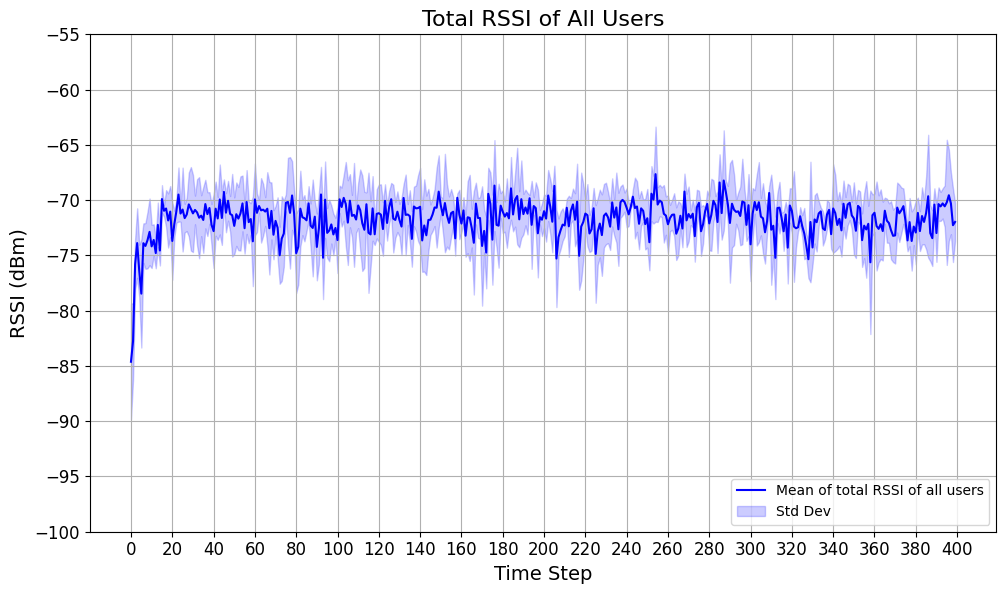

In [9]:
# rfs_sum = 10 ** (rfs / 10)  # Convert dBm to linear scale
rfs_sum = rfs.sum(dim=-1)
rfs_sum = 10 * torch.log10(rfs_sum) + 30  # Convert dBm
all_rfs_sum = rfs_sum.mean(dim=0)[0]
all_rfs_std = rfs_sum.std(dim=0)[0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(all_rfs_sum, label='Mean of total RSSI of all users', color='blue')
ax.fill_between(range(len(all_rfs_sum)), 
                all_rfs_sum - all_rfs_std, 
                all_rfs_sum + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ax.set_title('Total RSSI of All Users', fontsize=16)
ax.set_xlabel('Time Step',  fontsize=14)
ax.set_ylabel('RSSI (dBm)',  fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

## Mean RSSI of all users with different seeds

rfs_mean shape: torch.Size([4, 1, 400])
all_rfs_mean shape: torch.Size([400])
all_rfs_std shape: torch.Size([400])


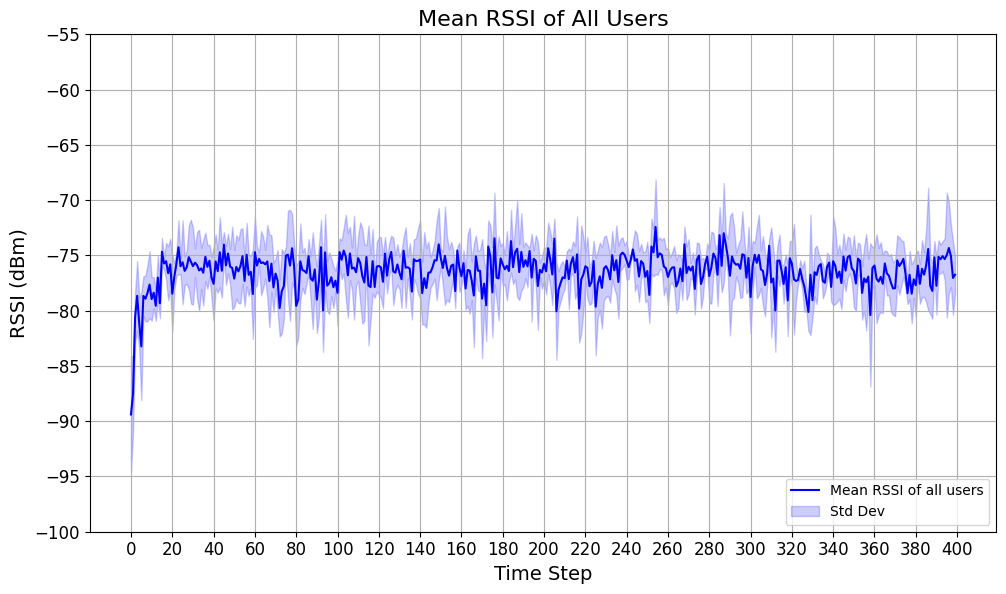

In [10]:
rfs_mean = rfs.mean(dim=-1)
# convert to dBm from linear scale
rfs_mean = 10 * torch.log10(rfs_mean)  + 30.0 # Adjusting for dBm scale
# rfs_mean.shape
# rfs_mean = rfs_mean[1:, ...]
print(f"rfs_mean shape: {rfs_mean.shape}")
all_rfs_mean = rfs_mean.mean(dim=0)[0]
all_rfs_std = rfs_mean.std(dim=0)[0]
print(f"all_rfs_mean shape: {all_rfs_mean.shape}")
print(f"all_rfs_std shape: {all_rfs_std.shape}")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(all_rfs_mean, label='Mean RSSI of all users', color='blue')
ax.fill_between(range(len(all_rfs_mean)), 
                all_rfs_mean - all_rfs_std, 
                all_rfs_mean + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ax.set_title('Mean RSSI of All Users', fontsize=16)
ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('RSSI (dBm)', fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

## Tracking with Genetic Algorithm

In [11]:
ga_files = []

for file in glob.glob('/home/hieule/research/saris_revised/test_local_assets/hallway_1ue_ga/*.pt'):
    if 'best_focal_point' in file:
        ga_files.append(file)
ga_files.sort(key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))

# 

In [12]:
ga_results = torch.load('/home/hieule/research/saris_revised/test_local_assets/hallway_1ue_ga/best_focal_point_1.pt', weights_only=False)
ga_results['best_rssi']

array([-82.670715, -90.59617 , -77.59884 ], dtype=float32)

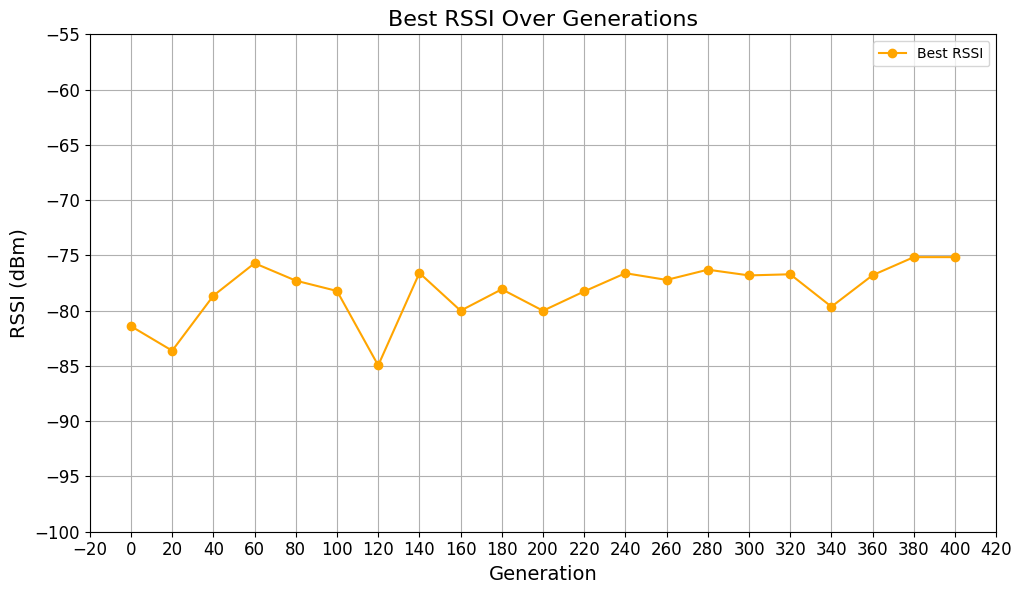

In [13]:
bests = []
for file in ga_files:
    ga_results = torch.load(file, weights_only=False)
    bests.append(np.mean(ga_results['best_rssi']))
    
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(bests)*20)[::20], bests, marker='o', label='Best RSSI', color='orange')
ax.set_title('Best RSSI Over Generations', fontsize=16)
ax.set_xlabel('Generation', fontsize=14)
ax.set_ylabel('RSSI (dBm)', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

## GA vs DRL

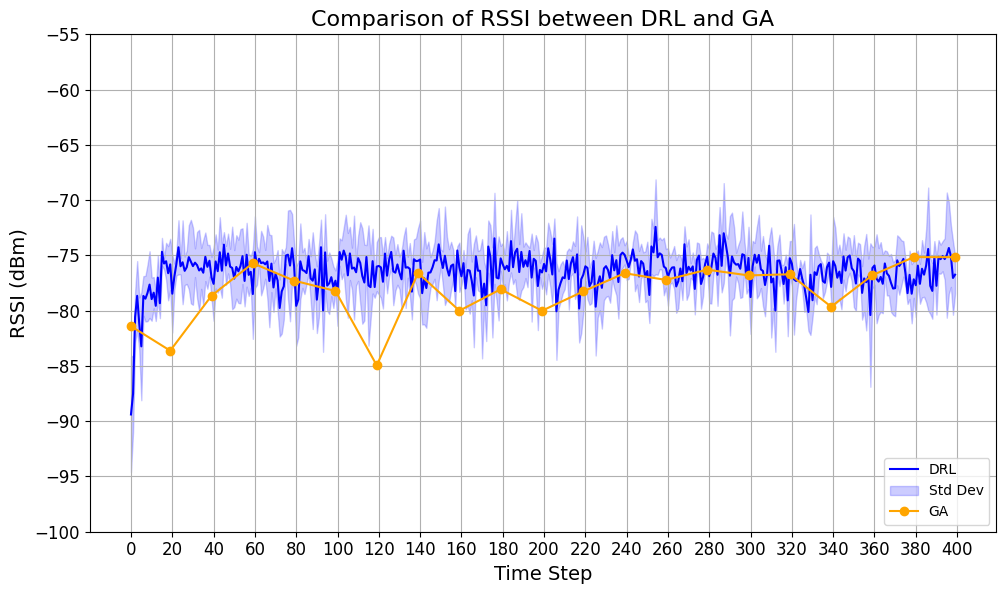

In [14]:
# plot the two graphs above on the same figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(all_rfs_mean, label='DRL', color='blue')
ax.fill_between(range(len(all_rfs_mean)), 
                all_rfs_mean - all_rfs_std, 
                all_rfs_mean + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ga_range = range(len(bests)*20)[::20]
ga_range = [t - 1 for t in ga_range]  # Adjusting to match the time steps
ga_range[0] = 0  # Ensure the first point starts at 0
ax.plot(ga_range, bests, marker='o', label='GA', color='orange')
ax.set_title('Comparison of RSSI between DRL and GA', fontsize=16)
ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('RSSI (dBm)', fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

In [15]:
def smooth(data, window_size=5):
    """Smooth the data using a Gaussian moving average filter."""
    # first, pad the data with zeros
    pad_size = window_size + 3
    data = np.pad(data, (pad_size, pad_size), mode="edge")
    # then, apply the Gaussian moving average filter
    kernel = np.exp(-0.5 * (np.arange(-pad_size, pad_size + 1) / 1) ** 2)
    kernel /= np.sum(kernel)
    smoothed_data = np.convolve(data, kernel, mode="same")
    # remove the padding
    smoothed_data = smoothed_data[pad_size:-pad_size]
    return smoothed_data

rfs_0 shape: (400,)


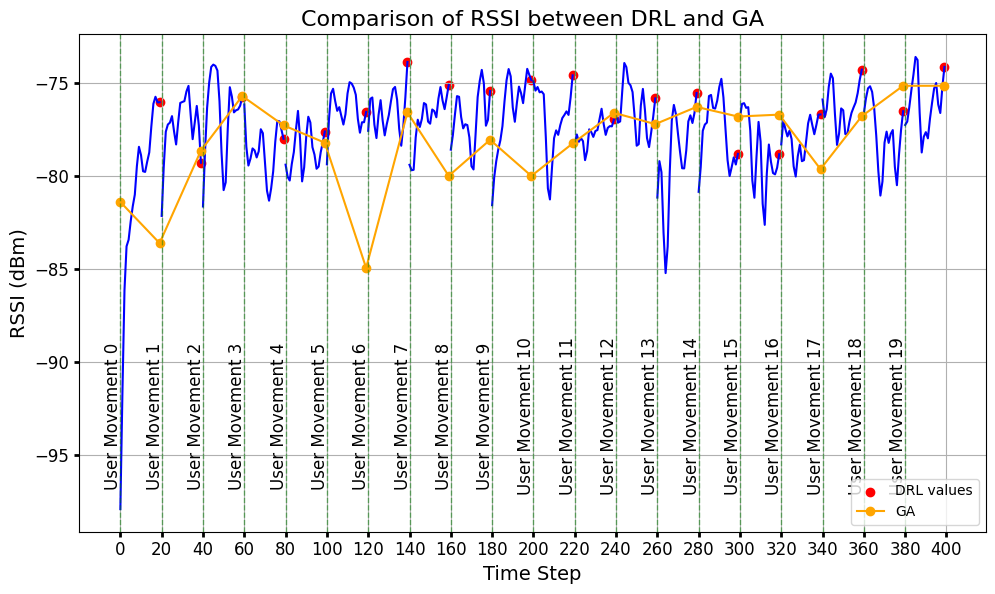

In [40]:
# plot the two graphs above on the same figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

rfs_0 = rfs[0, 0]
rfs_0 = 10 * torch.log10(rfs_0) + 30
# smooth the rfs_0 with a moving average using convolution
rfs_0 
rfs_0 = rfs_0.cpu().numpy()
rfs_0 = rfs_0.mean(axis=-1)  # Average over the users
tmp_0 = rfs_0[0].copy()

# smooth data for every 20 steps only
last_drls = []
rfsss = []
for i in range(0, len(rfs_0), 20):
    tmp_rfs = rfs_0[i:i+20]
    tmp_rfs[-1] += 1
    tmp_rfs = smooth(tmp_rfs, window_size=3)
    drl_range = range(len(tmp_rfs))
    drl_range = [i + t for t in range(20)]
    ax.plot(drl_range, tmp_rfs, color='blue', alpha=1)  # Plot each segment
    last_drls.append(tmp_rfs[-1])
    rfsss.append(tmp_rfs)
rfs_0 = np.concatenate(rfsss)
# rfs_0 = smooth(rfs_0, window_size=5)
print(f"rfs_0 shape: {rfs_0.shape}")
# ax.plot(rfs_0, label='DRL Smoothed', color='blue')
drl_range = range(len(rfs_0))[::20]
drl_range = [t + 19 for t in drl_range]  # Adjusting to match the time steps
ax.scatter(drl_range, last_drls, label='DRL values', color='red')
# plot points for the last DRL values
# ax.plot(tmp_0, label='DRL Original', color='blue', linestyle='o')
# plot the last DRL values

# ax.plot(10 * torch.log10(rfs[0,0])  + 30.0, label='DRL', color='black')
# ax.fill_between(range(len(all_rfs_mean)), 
#                 all_rfs_mean - all_rfs_std, 
#                 all_rfs_mean + all_rfs_std, 
#                 color='blue', alpha=0.2, label='Std Dev')
ga_range = range(len(bests)*20)[::20]
ga_range = [t - 1 for t in ga_range]  # Adjusting to match the time steps
ga_range[0] = 0  # Ensure the first point starts at 0
ax.plot(ga_range, bests, marker='o', label='GA', color='orange')
ax.set_title('Comparison of RSSI between DRL and GA', fontsize=16)
ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('RSSI (dBm)', fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
# ax.set_ylim(-100, -55)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)


plt.axvline(x=0, color="green", linestyle="--", linewidth=1, alpha=0.5)
for i in range(20, rfs_0.shape[0], 20):
    plt.axvline(x=i, color="green", linestyle="--", linewidth=1, alpha=0.5)
# label for vertical lines as episode number
plt.text(
    1,
    rfs_0.min()+5,
    "User Movement 0",
    rotation=90,
    verticalalignment="center",
    horizontalalignment="right",
    fontsize=12,
)
for i in range(1, 20):
    plt.text(
        i * 20 +1,
        rfs_0.min()+5,
        f"User Movement {i}",
        rotation=90,
        verticalalignment="center",
        horizontalalignment="right",
        fontsize=12,
    )
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

## User RSSI for different Scenes

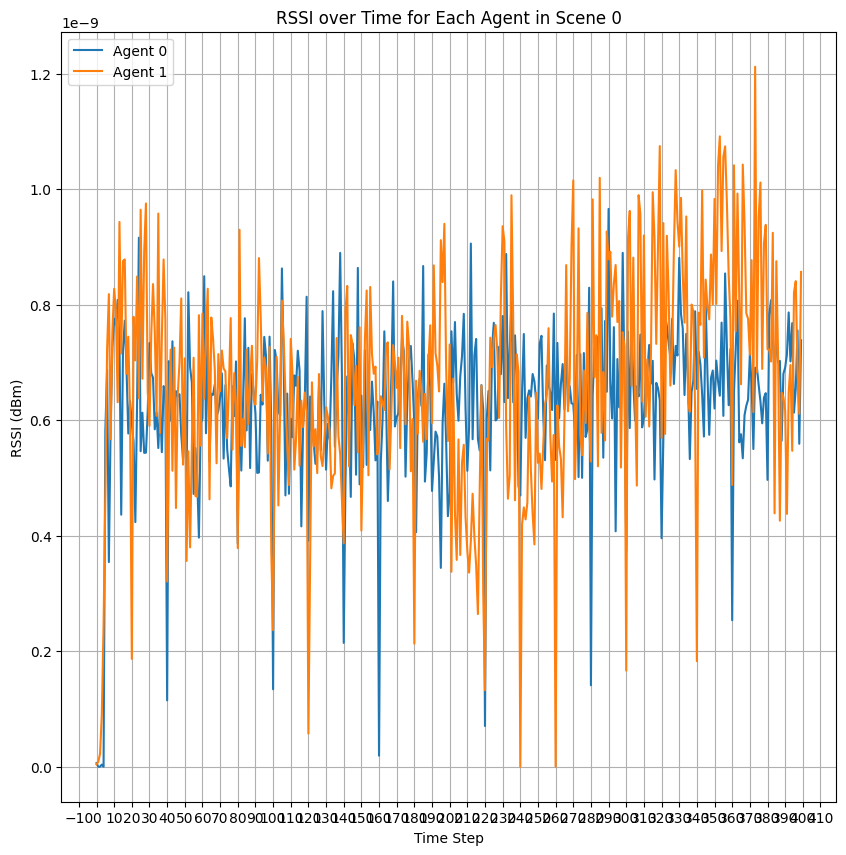

In [18]:
scene0 = rfs[0, 0]
scene0.shape
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scene0[:, 0, 0].numpy(), label='Agent 0')
ax.plot(scene0[:, 1, 0].numpy(), label='Agent 1')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI over Time for Each Agent in Scene 0')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()

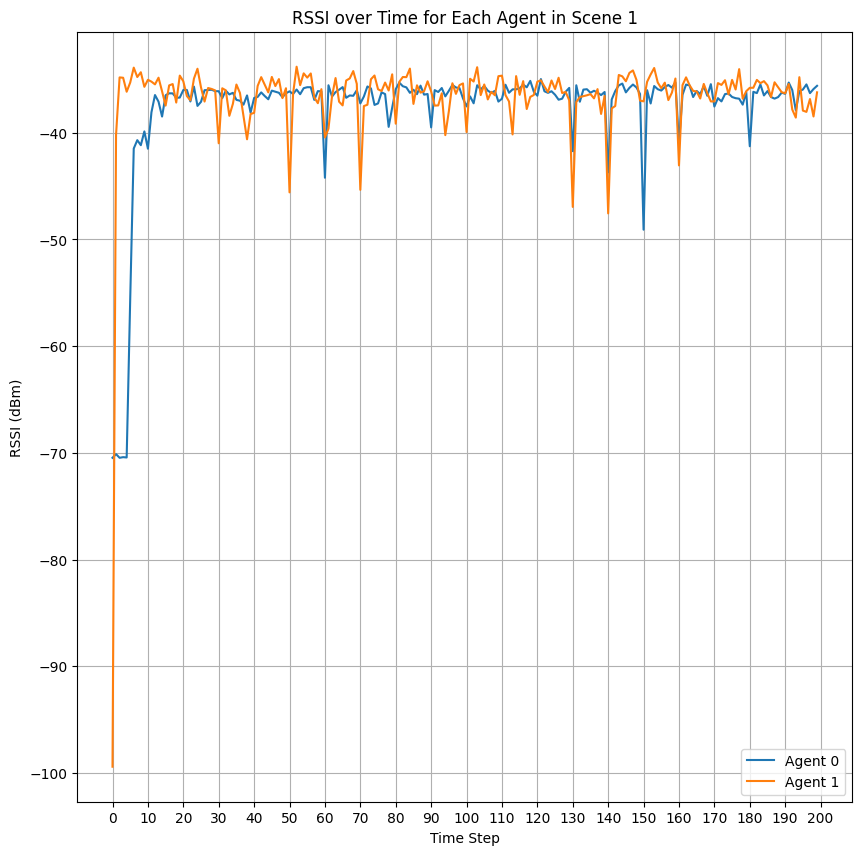

In [39]:
scene1 = rfs[1, 0]
scene1.shape
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scene1[:, 0, 0].numpy(), label='Agent 0')
ax.plot(scene1[:, 1, 0].numpy(), label='Agent 1')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI over Time for Each Agent in Scene 1')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()

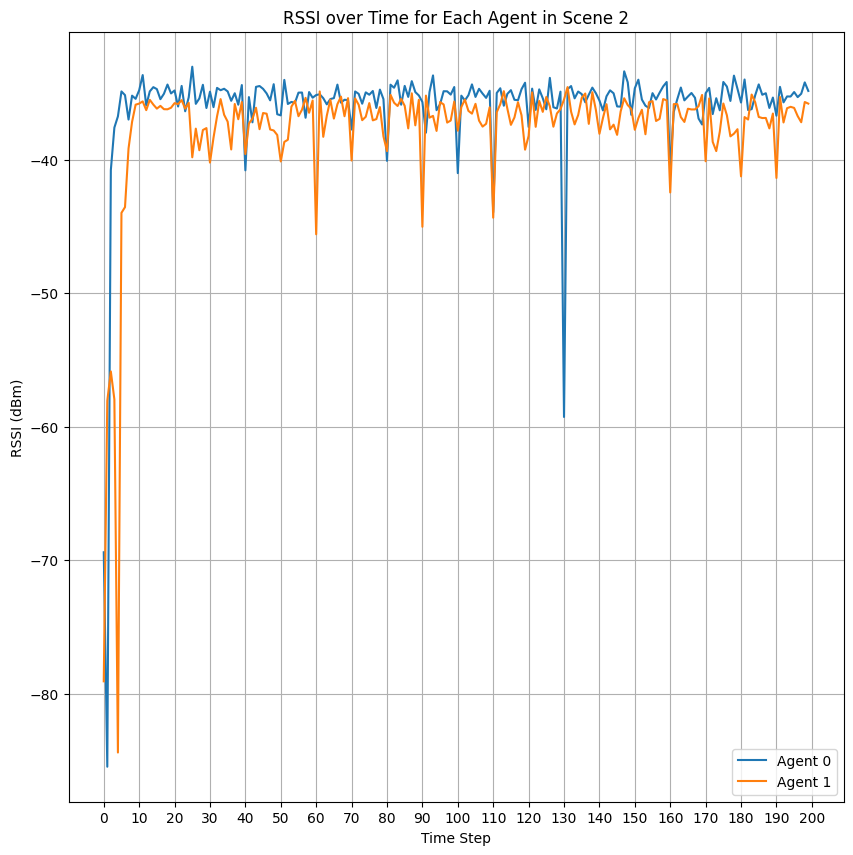

In [40]:
scene2 = rfs[2, 0]
scene2.shape
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scene2[:, 0, 0].numpy(), label='Agent 0')
ax.plot(scene2[:, 1, 0].numpy(), label='Agent 1')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI over Time for Each Agent in Scene 2')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()